In [1]:
from IPython.display import Image, display
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
import torch.distributions.constraints as constraints
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [125]:
print(pyro.__version__)

0.3.2


# Create a recommendation system for people to watch movies.


The context of the problem is a table of movies and whether or not people like the movie. The recommendation system works by categorizing a movie into traits (trait) and people into whether or not they like certain traits (preference). Given ratings of a certain user, you can use inference to work backwards and set their preferences. 
Each trait needs to be rooted by a movie; it defines a trait axis. Given data of all users you can determine where movies fall relative to the rooted movie using inference and working backwards again.

# Theoretical Example

Can you tell whether person 3 likes movie B, C, D, and E?

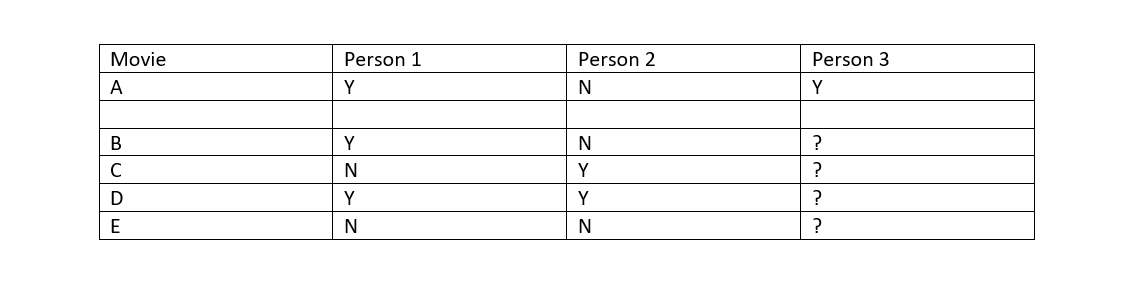

In [91]:
display(Image(filename="sampletable.png"))

# Basic model
Let's start with a simple case. Assume there is one person and several movies. Movies only has one trait(feature). Corresponding factor graph is shown below.

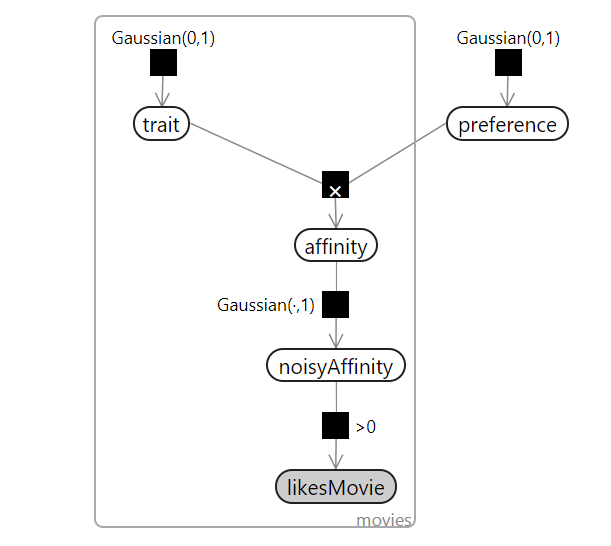

In [88]:
display(Image(filename="factorgraph1.png"))

Given trait mean and standard deviation for each movie, and the preference trait for the person this model can compute if the person likes the movie.

From the graph we can write out the full joint as

$$ p(l, t, p, \tilde{A}; \mu_t,\sigma_t,\mu_p,\sigma_p) = p(p)*\prod_{i=1}^N p(t_i) * p(l_i \mid \tilde{A}_i) p(\tilde{A}_i \mid t_i,p) $$

where $l$ is the likesMovie, $t$ is the trait, $p$ is the preferance, $\tilde{A}$ is the noisyAffinity

## A toy example
1 person, 10 movies

In [13]:
y_temp = np.array([1 if(i%2==0) else 0 for i in range(0, 10)])
y = torch.Tensor(y_temp.astype(np.float32))
print(y_temp)


[1 0 1 0 1 0 1 0 1 0]


## model and guides

In [14]:
def model_multi_movies(y):
    mean_pref = torch.tensor(0.)
    std_pref = torch.tensor(1.)
    pref = pyro.sample("pref",dist.Normal(mean_pref,std_pref))

    mean_trait = torch.tensor(0.)
    std_trait = torch.tensor(1.)
    
    known_trait = pyro.sample("known_trait", dist.Normal(mean_trait, std_trait), obs = torch.tensor(1.))
    noisy_affinity = pyro.sample('noisy_affinity_0', dist.Normal(known_trait*pref,torch.tensor(0.2)))
    likes_movie = pyro.sample('likes_movie_0',dist.Bernoulli(torch.sigmoid(noisy_affinity)), obs=y[0])

    with pyro.plate("movies", len(y)-1):
        trait = pyro.sample("trait", dist.Normal(mean_trait,std_trait))
        noisy_affinity = pyro.sample('noisy_affinity'.format(i+1), dist.Normal(trait*pref,torch.tensor(0.2)))
        likes_movie = pyro.sample('likes_movie',dist.Bernoulli(torch.sigmoid(noisy_affinity)), obs=y[1:])

def guide(y):
    mean_pref = pyro.param("mean_pref",torch.tensor(10.0))
    std_pref = pyro.param("std_pref",torch.tensor(1.0),constraint=constraints.positive)
    pref = pyro.sample("pref",dist.Normal(mean_pref,std_pref))
    mean_trait = pyro.param("mean_trait", torch.zeros(len(y)-1))
    std_trait = pyro.param("std_trait", torch.ones(len(y)-1),constraint=constraints.positive) 
    
    with pyro.plate("movies", len(y)-1):
        trait = pyro.sample("trait" ,dist.Normal(mean_trait,std_trait))


In [15]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model=model_multi_movies,
                     guide=guide,
                     optim=pyro.optim.SGD({"lr": 0.01, "momentum":0.001}),
                     loss=pyro.infer.Trace_ELBO())
losses =[]

num_steps = 300
for i in range(num_steps):
    losses.append(svi.step(y))
    if(i%10==0):
        print(".", end='')


..............................

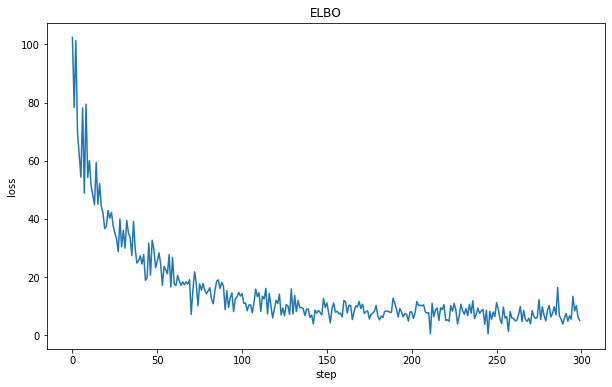

In [16]:
plt.figure(figsize=(10,6))    
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
plt.show()

## Check training accuracy

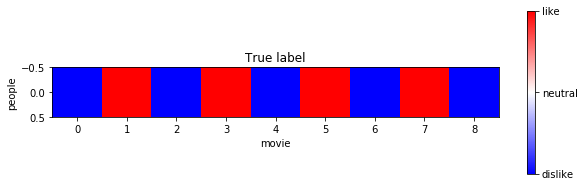

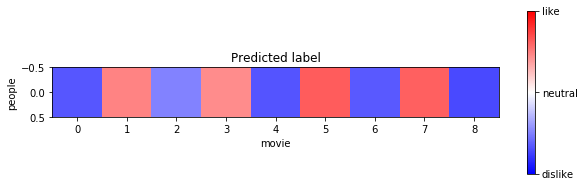

In [17]:
y[y==0]=-1
fig = plt.figure(figsize=(10,3)) 
plt.title('True label')
cax = plt.imshow(y[1:].reshape((1,9)), cmap='bwr', vmin=-1., vmax=1.)
cbar = fig.colorbar(cax, ticks=[-1, 0, 1])
cbar.ax.set_yticklabels(['dislike', 'neutral', 'like'])  # vertically oriented colorbar
plt.xlabel('movie')
plt.ylabel('people')
plt.show()


testing_values = pyro.param("mean_pref").data.mul( pyro.param("mean_trait").data )
fig = plt.figure(figsize=(10,3)) 
plt.title('Predicted label')
cax = plt.imshow(testing_values.reshape((1,9)), cmap='bwr', vmin=-1., vmax=1.)
cbar = fig.colorbar(cax, ticks=[-1, 0, 1])
cbar.ax.set_yticklabels(['dislike', 'neutral', 'like'])  # vertically oriented colorbar
plt.xlabel('movie')
plt.ylabel('people')
plt.show()


This model correctly predicts whether or not someone likes a movie on data we trained on. This is not particularly impressive, but it took some effort figuring out how to set up the model, guide, what to initialize variables at, implying inference, etc.

We cannot guess if a person will like a movie he/she hasn't seen yet since the trait variable for a movie is currently trained on only one person.

Next step, we are going to try more complex models.

# Multiple traits multiple people model
We test the model with 8 people, 100 movies, and 30 traits. We are still testing the model on training data, but this is a more complicated scenario.

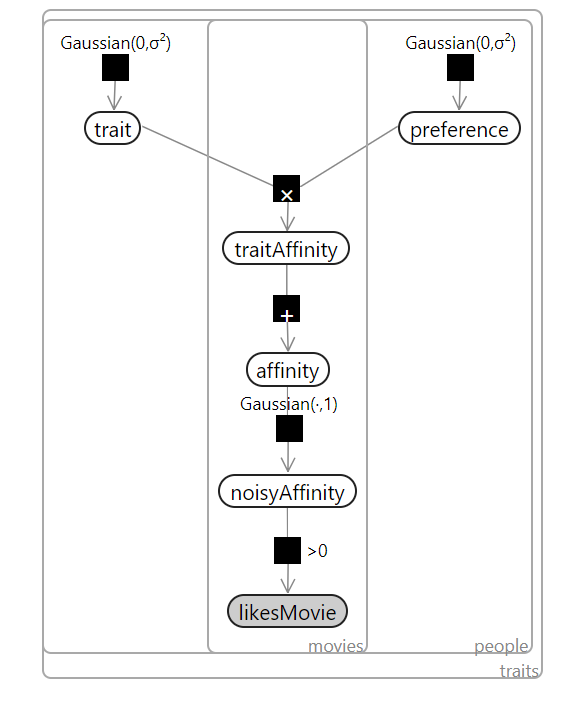

In [18]:
display(Image(filename="factorgraph2.png"))

## model and guide

In [19]:
def model_multi_people(y, num_traits):
    num_people, num_movies = y.shape
    mean_pref = torch.tensor(0.)
    std_pref = torch.tensor(1.)
    mean_trait = torch.tensor(0.)
    std_trait = torch.tensor(1.)
    
    with pyro.plate("traits", num_traits):
        with pyro.plate("people", num_people):
            pref = pyro.sample("pref",dist.Normal(mean_pref,std_pref))
        with pyro.plate("movies", num_movies - num_traits):
            trait = pyro.sample("trait", dist.Normal(mean_trait,std_trait))
    
    known_trait = pyro.sample("known_trait", dist.Normal(mean_trait, std_trait), obs = torch.eye(num_traits))
    known_affinity = torch.mm(pref, known_trait.transpose(0,1))
    known_noisy_affinity = pyro.sample('known_noisy_affinity', dist.Normal(known_affinity,torch.tensor(0.2)))
    known_likes_movie = pyro.sample('known_likes_movie',dist.Bernoulli(torch.sigmoid(known_noisy_affinity)), obs=y[:,:num_traits])
    
    affinity = torch.mm(pref, trait.transpose(0,1))
    noisy_affinity = pyro.sample('noisy_affinity', dist.Normal(affinity, torch.tensor(0.2)))
    likes_movie = pyro.sample('likes_movie',dist.Bernoulli(torch.sigmoid(noisy_affinity)), obs=y[:,num_traits:])
    
def guide(y, num_traits):
    num_people, num_movies = y.shape
    
    mean_pref = pyro.param("mean_pref", torch.zeros(num_people, num_traits)+5)
    std_pref = pyro.param("std_pref", torch.ones(num_people, num_traits))
    mean_trait = pyro.param("mean_trait", torch.zeros(num_movies-num_traits,num_traits)+5)
    std_trait = pyro.param("std_trait", torch.ones(num_movies-num_traits,num_traits))
    
    with pyro.plate("traits", num_traits):
        with pyro.plate("people", num_people):
            pref = pyro.sample("pref",dist.Normal(mean_pref,std_pref))
        with pyro.plate("movies", num_movies - num_traits):
            trait = pyro.sample("trait", dist.Normal(mean_trait,std_trait))

def check_accuracy(y):
    testing_values = torch.mm(pyro.param("mean_pref").data,pyro.param("mean_trait").data.transpose(0,1))
    testing_result = torch.sign(testing_values)
    testing_result[testing_result==-1]=0.
    a,b = testing_result.shape
    return torch.sum(testing_result == y[:,num_traits:]).float()/(a*b)


In [35]:
# generate fake data  (num_people, num_movies)
y = torch.randint(2, size = (8,100)).float()

In [36]:
# inference
pyro.clear_param_store()
svi = pyro.infer.SVI(model=model_multi_people,
                     guide=guide,
                     optim=pyro.optim.SGD({"lr": 0.0003, "momentum":0.0002}),
                     loss=pyro.infer.Trace_ELBO())
losses =[]
accuracies =[]
num_steps = 10000
num_traits = 30
for i in range(num_steps):
    losses.append(svi.step(y, num_traits))
    if(i%200==0):
        accuracies.append(check_accuracy(y) )
        print(".", end='')


..................................................

## check performance

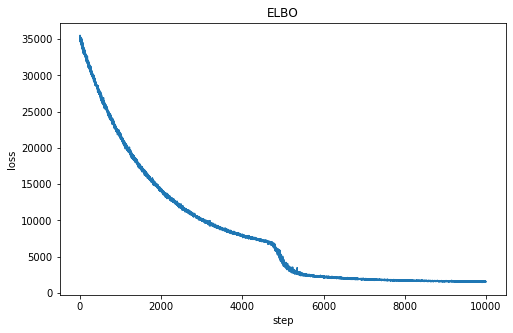

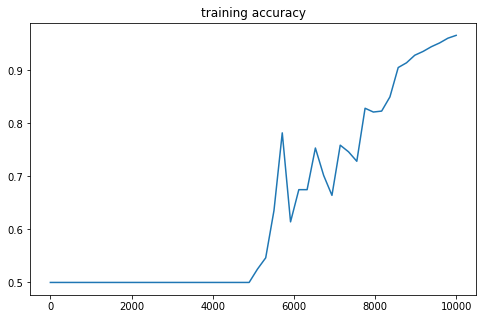

In [37]:
plt.figure(figsize=(8,5))    
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
plt.show()
plt.figure(figsize=(8,5))    
plt.plot(np.linspace(0,num_steps,len(accuracies)),accuracies)
plt.title("training accuracy")
plt.show()

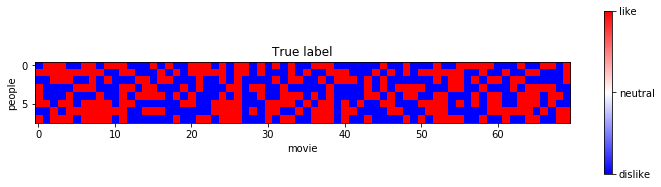

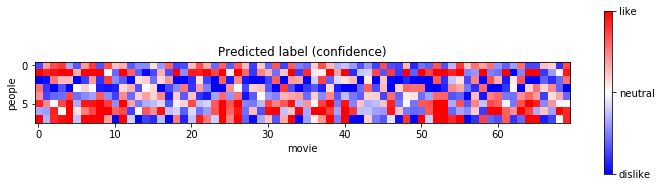

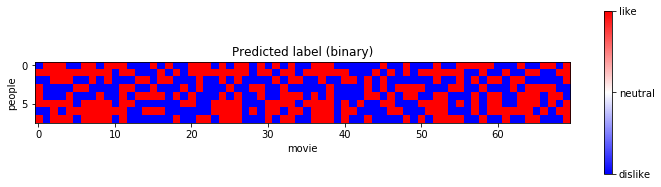

In [38]:
yplot = y.clone()
yplot[yplot==0]=-1
fig = plt.figure(figsize=(12,3)) 
cax = plt.imshow(yplot[:,num_traits:], cmap='bwr', vmin=-1., vmax=1.)
cbar = fig.colorbar(cax, ticks=[-1, 0, 1])
cbar.ax.set_yticklabels(['dislike', 'neutral', 'like'])  # vertically oriented colorbar
plt.title('True label')
plt.xlabel('movie')
plt.ylabel('people')
plt.show()


testing_values = torch.mm(pyro.param("mean_pref").data,pyro.param("mean_trait").data.transpose(0,1))
fig = plt.figure(figsize=(12,3)) 
cax = plt.imshow(testing_values, cmap='bwr', vmin=-1., vmax=1.)
cbar = fig.colorbar(cax, ticks=[-1, 0, 1])
cbar.ax.set_yticklabels(['dislike', 'neutral', 'like'])  # vertically oriented colorbar
plt.title('Predicted label (confidence)')
plt.xlabel('movie')
plt.ylabel('people')
plt.show()

testing_result = torch.sign(testing_values)
fig = plt.figure(figsize=(12,3)) 
cax = plt.imshow(testing_result, cmap='bwr', vmin=-1., vmax=1.)
cbar = fig.colorbar(cax, ticks=[-1, 0, 1])
cbar.ax.set_yticklabels(['dislike', 'neutral', 'like'])  # vertically oriented colorbar
plt.title('Predicted label (binary)')
plt.xlabel('movie')
plt.ylabel('people')
plt.show()


In [39]:
print('training accuracy')
check_accuracy(y)

training accuracy


tensor(0.9679)

 The top plot are the true values, the middle plot contains the estimation with variance added, and the last plot is the estimate with no variance. Red means liked movie, blue dislike, white inconclusive.

# Mask out half data as test data
The real test data we have has lots and lots of missing data. To incorporate the missing data into our framework we randomly replaced half of our data set with -1 while training the model. Pyro contains a mask function which implements this functionality.


In [44]:
def model_with_mask(y, num_traits):
    num_people, num_movies = y.shape
    mean_pref = torch.tensor(0.)
    std_pref = torch.tensor(1.)
    mean_trait = torch.tensor(0.)
    std_trait = torch.tensor(1.)
    
    with pyro.plate("traits", num_traits):
        with pyro.plate("people", num_people):
            pref = pyro.sample("pref",dist.Normal(mean_pref,std_pref))
        with pyro.plate("movies", num_movies - num_traits):
            trait = pyro.sample("trait", dist.Normal(mean_trait,std_trait))
    
    known_trait = pyro.sample("known_trait", dist.Normal(mean_trait, std_trait), obs = torch.eye(num_traits))
    known_affinity = torch.mm(pref, known_trait.transpose(0,1))
    known_noisy_affinity = pyro.sample('known_noisy_affinity', dist.Normal(known_affinity,torch.tensor(0.2)))
    is_observed = (y[:,:num_traits] != -1).byte()
    y_temp = y[:,:num_traits]
    y_temp[y_temp==-1] = 1
    with pyro.poutine.mask(mask=is_observed):
        known_likes_movie = pyro.sample('known_likes_movie',dist.Bernoulli(torch.sigmoid(known_noisy_affinity)), obs=y_temp)
    
    affinity = torch.mm(pref, trait.transpose(0,1))
    noisy_affinity = pyro.sample('noisy_affinity', dist.Normal(affinity, torch.tensor(0.2)))
    
    is_observed = (y[:,num_traits:] != -1).byte()
    y_temp = y[:,num_traits:]
    y_temp[y_temp==-1] = 1
    with pyro.poutine.mask(mask=is_observed):
        likes_movie = pyro.sample('likes_movie',dist.Bernoulli(torch.sigmoid(noisy_affinity)), obs=y_temp)
    
def guide(y, num_traits):
    num_people, num_movies = y.shape
    
    mean_pref = pyro.param("mean_pref", torch.zeros(num_people, num_traits)+2)
    std_pref = pyro.param("std_pref", torch.ones(num_people, num_traits))
    mean_trait = pyro.param("mean_trait", torch.zeros(num_movies-num_traits,num_traits)+2)
    std_trait = pyro.param("std_trait", torch.ones(num_movies-num_traits,num_traits))
    
    with pyro.plate("traits", num_traits):
        with pyro.plate("people", num_people):
            pref = pyro.sample("pref",dist.Normal(mean_pref,std_pref))
        with pyro.plate("movies", num_movies - num_traits):
            trait = pyro.sample("trait", dist.Normal(mean_trait,std_trait))



In [48]:
# generate fake data  (num_people, num_movies)
y_truth = torch.randint(2, size = (8,100)).float()
y = y_truth.clone()
for i in range(8):
    missing_index = np.random.choice(np.arange(0,100), replace=False, size=np.random.randint(low=30, high=50))
    for index in missing_index:
        y[i, index] = -1.

y_which_missing = torch.zeros_like(y)
y_which_missing[y==-1]=1.

y_truth_01 = torch.clone(y_truth)
y_truth_01[y_truth==0]=-1


In [49]:
# inference
pyro.clear_param_store()
svi = pyro.infer.SVI(model=model_with_mask,
                     guide=guide,
                     optim=pyro.optim.SGD({"lr": 0.0003, "momentum":0.0002}),
                     loss=pyro.infer.Trace_ELBO())
losses =[]
training_acc =[]
testing_acc =[]

num_steps = 10000
num_traits = 30
for i in range(num_steps):
    losses.append(svi.step(y, num_traits))
    if(i%100==0):
        testing_values = torch.mm(pyro.param("mean_pref").data, pyro.param("mean_trait").data.transpose(0,1))
        total = torch.sum(y_which_missing[:,num_traits:])
        count = torch.sum(y_which_missing[:,num_traits:]*(y_truth_01[:,num_traits:] == torch.sign(testing_values)).float())
        testing_acc.append(count/total)
        total = torch.sum(y_which_missing[:,num_traits:]-1)
        count = torch.sum((y_which_missing[:,num_traits:]-1)*(y_truth_01[:,num_traits:] == torch.sign(testing_values)).float())
        training_acc.append(count/total)
        print(".", end='')


....................................................................................................

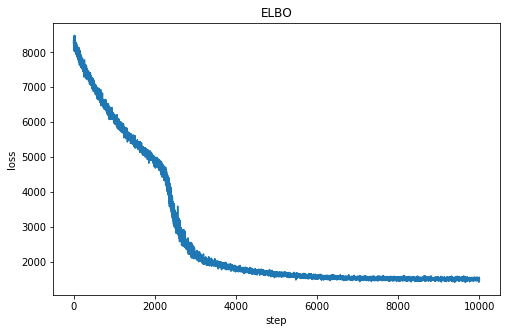

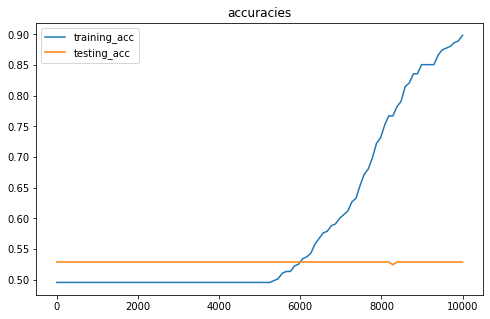

In [50]:
plt.figure(figsize=(8,5))    
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
plt.show()
plt.figure(figsize=(8,5))    
plt.plot(np.linspace(0,num_steps,len(training_acc)), training_acc, label='training_acc')
plt.plot(np.linspace(0,num_steps,len(testing_acc)), testing_acc, label='testing_acc')
plt.title("accuracies")
plt.legend()
plt.show()

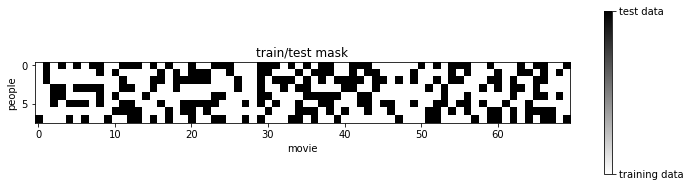

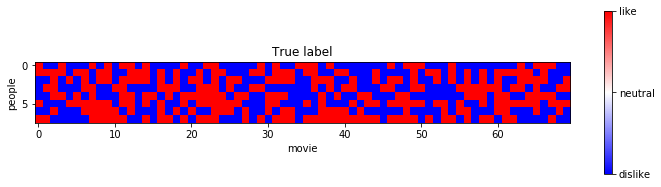

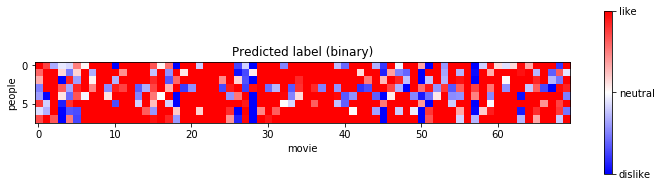

In [54]:
# visualize
fig = plt.figure(figsize=(12,3)) 
cax = plt.imshow(y_which_missing[:,num_traits:], cmap='binary', vmin=0, vmax=1.)
cbar = fig.colorbar(cax, ticks=[0, 1])
cbar.ax.set_yticklabels(['training data', 'test data'])  # vertically oriented colorbar
plt.title('train/test mask')
plt.xlabel('movie')
plt.ylabel('people')
plt.show()

fig = plt.figure(figsize=(12,3)) 
cax = plt.imshow(y_truth_01[:,num_traits:], cmap='bwr', vmin=-1., vmax=1.)
cbar = fig.colorbar(cax, ticks=[-1, 0, 1])
cbar.ax.set_yticklabels(['dislike', 'neutral', 'like'])  # vertically oriented colorbar
plt.title('True label')
plt.xlabel('movie')
plt.ylabel('people')
plt.show()

prediction = torch.mm(pyro.param("mean_pref").data,pyro.param("mean_trait").data.transpose(0,1))
fig = plt.figure(figsize=(12,3)) 
cax = plt.imshow(prediction, cmap='bwr', vmin=-1., vmax=1.)
cbar = fig.colorbar(cax, ticks=[-1, 0, 1])
cbar.ax.set_yticklabels(['dislike', 'neutral', 'like'])  # vertically oriented colorbar
plt.title('Predicted label (binary)')
plt.xlabel('movie')
plt.ylabel('people')
plt.show()

In [52]:
testing_values = torch.mm(pyro.param("mean_pref").data,pyro.param("mean_trait").data.transpose(0,1))
# testing error
total = torch.sum(y_which_missing[:,num_traits:])
count = torch.sum(y_which_missing[:,num_traits:]*(y_truth_01[:,num_traits:] == torch.sign(testing_values)).float())
print('testing acc',count/total)
# training error
total = torch.sum(y_which_missing[:,num_traits:]-1)
count = torch.sum((y_which_missing[:,num_traits:]-1)*(y_truth_01[:,num_traits:] == torch.sign(testing_values)).float())
print('training acc',count/total)


testing acc tensor(0.5289)
training acc tensor(0.9015)


The training accuracy is good, but the testing accuracy is random 50%. We think this is because this fake data has no meaning. This system can only guess movies people like by grouping people together based on their preferences. Since this data is random there are no preferences.

# Test on Real Data

Next we imported the real data from movielens and test our model.

In [55]:
ratings = pd.read_csv('ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [56]:
"""
loading and processing real data
the matrix is 610 by 9724.
"""

ratings = pd.read_csv('ratings.csv')
person_index = list(ratings['userId'].value_counts().keys())
movie_index = list(ratings['movieId'].value_counts().keys())

num_of_users = len(person_index)
num_of_movies = len(movie_index)

ratings = ratings.values[:,:3]

mat  = -1.0* np.ones((num_of_users, num_of_movies), dtype=int)
for idx, rate in enumerate(ratings):
    if(idx%1000 == 0):
        print(".", end='')
    row = person_index.index(rate[0])
    col = movie_index.index(rate[1])
    if rate[2] > 3:  
        mat[row][col] = 1.
    else:
        mat[row][col] = 0.

data = torch.tensor(mat).float()
torch.save(data, 'data.pt')

.....................................................................................................

## Visualize real data. How sparse it is!

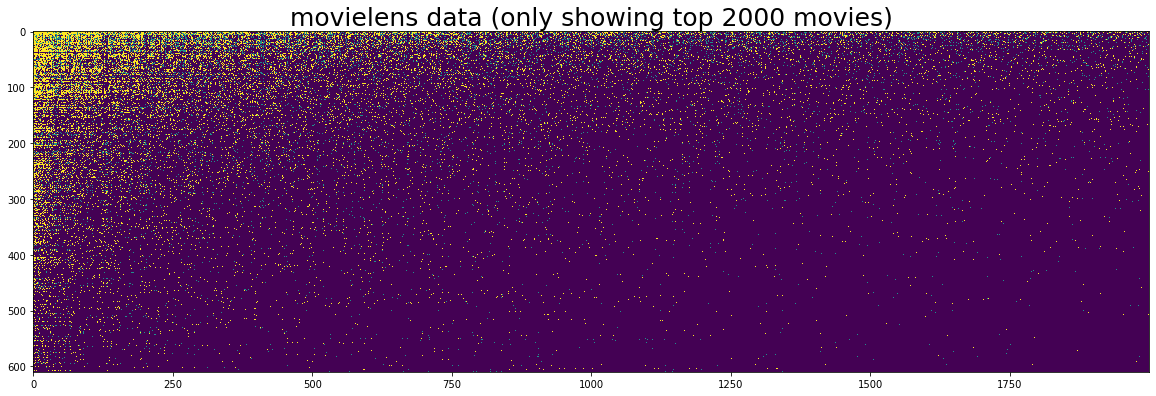

In [65]:
plt.figure(figsize = (20,10))
plt.title('movielens data (only showing top 2000 movies)',fontsize = 25)
plt.imshow(data[:,:2000])
plt.show()

## select top 8 people and top 100 movies

In [94]:
# adding self-made mask
data_truth = torch.load('data.pt').float()
num_people = 8
num_movies = 100
data = data_truth[:num_people,:num_movies].clone()
data_real_missing = torch.zeros_like(data_truth[:num_people,:num_movies])
data_real_missing[data_truth[:num_people,:num_movies]==-1]=1.

for i in range(num_people):
    missing_index = np.random.choice(np.arange(0,num_movies), replace=False, size=np.random.randint(low=15, high=25))
    for index in missing_index:
        data[i, index] = -1.

data_which_missing = torch.zeros_like(data)
data_which_missing[data==-1] = 1.

data_truth_01 = data_truth[:num_people,:num_movies].clone()
data_truth_01[data_truth[:num_people,:num_movies]==0] = -1
data_truth_01[data_truth[:num_people,:num_movies]==-1] = -2



....................................................................................................

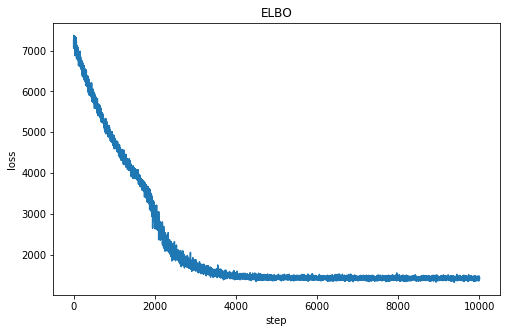

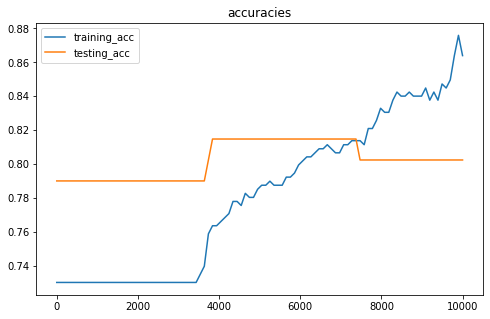

In [95]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model=model_with_mask,
                     guide=guide,
                     optim=pyro.optim.Adam({"lr": 0.0008, "betas": (0.90, 0.999)}),
#                      optim=pyro.optim.SGD({"lr": 0.0001, "momentum":0.0003}),
                     loss=pyro.infer.Trace_ELBO())
losses =[]
training_acc = []
testing_acc = []
num_steps = 10000
num_traits = 30
for i in range(num_steps):
    losses.append(svi.step(data, num_traits))
    if(i%100==0):
        testing_values = torch.mm(pyro.param("mean_pref").data, pyro.param("mean_trait").data.transpose(0,1))
        total = torch.sum(data_which_missing[:,num_traits:]!=data_real_missing[:,num_traits:])
        count = torch.sum((data_which_missing[:,num_traits:]!=data_real_missing[:,num_traits:]).float()*(data_truth_01[:,num_traits:] == torch.sign(testing_values)).float())
        testing_acc.append(count/total)
        total = torch.sum(data_which_missing[:,num_traits:]-1)
        count = torch.sum((data_which_missing[:,num_traits:]-1)*(data_truth_01[:,num_traits:] == torch.sign(testing_values)).float())
        training_acc.append(count/total)
        print(".", end='')
        
plt.figure(figsize=(8,5))    
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
plt.show()

plt.figure(figsize=(8,5))    
plt.plot(np.linspace(0,num_steps,len(training_acc)), training_acc, label='training_acc')
plt.plot(np.linspace(0,num_steps,len(testing_acc)), testing_acc, label='testing_acc')
plt.title("accuracies")
plt.legend()
plt.show()

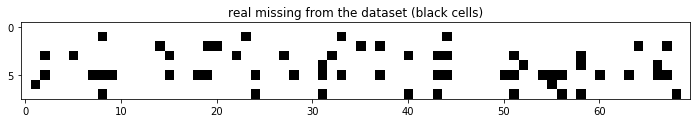

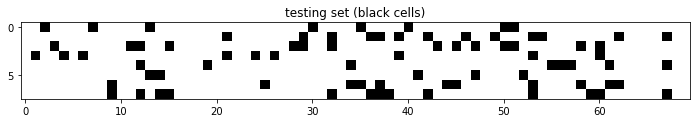

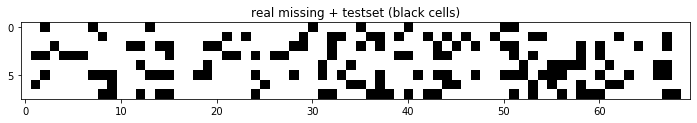

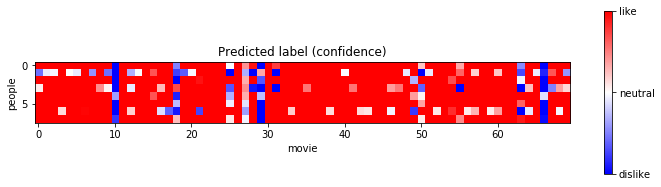

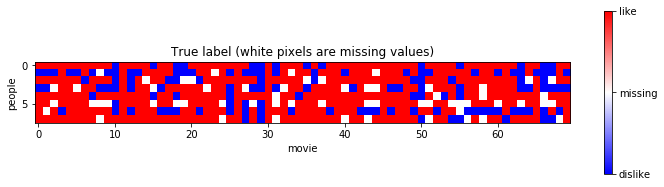

In [103]:
prediction = torch.mm(pyro.param("mean_pref").data,pyro.param("mean_trait").data.transpose(0,1))

plt.figure(figsize=(12,3)) 
plt.title('real missing from the dataset (black cells)')
plt.imshow(data_real_missing[:,num_traits:], cmap='binary', vmin=0, vmax=1.)
plt.show()


plt.figure(figsize=(12,3)) 
plt.title('testing set (black cells)')
plt.imshow((data_which_missing[:,num_traits:]!=data_real_missing[:,num_traits:]).float(), cmap='binary', vmin=0, vmax=1.)
plt.show()

plt.figure(figsize=(12,3)) 
plt.title('real missing + testset (black cells)')
plt.imshow(data_which_missing[:,num_traits:], cmap='binary', vmin=0, vmax=1.)
plt.show()

fig = plt.figure(figsize=(12,3)) 
cax = plt.imshow(prediction, cmap='bwr', vmin=-1., vmax=1.)
cbar = fig.colorbar(cax, ticks=[-1, 0, 1])
cbar.ax.set_yticklabels(['dislike', 'neutral', 'like'])  # vertically oriented colorbar
plt.title('Predicted label (confidence)')
plt.xlabel('movie')
plt.ylabel('people')
plt.show()

data_truth_02 = data_truth[:num_people,:num_movies].clone()
data_truth_02[data_truth[:num_people,:num_movies]==0] = -1
data_truth_02[data_truth[:num_people,:num_movies]==-1] = 0
fig = plt.figure(figsize=(12,3)) 
cax = plt.imshow(data_truth_02[:,num_traits:], cmap='bwr', vmin=-1., vmax=1.)
cbar = fig.colorbar(cax, ticks=[-1, 0, 1])
cbar.ax.set_yticklabels(['dislike', 'missing', 'like'])  # vertically oriented colorbar
plt.title('True label (white pixels are missing values)')
plt.xlabel('movie')
plt.ylabel('people')
plt.show()

In [104]:
confusion_train = np.zeros((2,2))
confusion_test = np.zeros((2,2))
for i in range(num_people):
    for j in range(num_movies-num_traits):
        if data_real_missing[i,j+num_traits] != 1:
            if data_which_missing[i,j+num_traits]!=data_real_missing[i,j+num_traits]: # testing set
                if data_truth[i,j+num_traits] == 1 and torch.sign(testing_values[i,j]).float() == 1:
                    confusion_test[0,0] = confusion_test[0,0] + 1
                elif data_truth[i,j+num_traits] == 1 and torch.sign(testing_values[i,j]).float() == -1:
                    confusion_test[1,0] = confusion_test[1,0] + 1
                elif data_truth[i,j+num_traits] == 0 and torch.sign(testing_values[i,j]).float() == 1:
                    confusion_test[0,1] = confusion_test[0,1] + 1
                elif data_truth[i,j+num_traits] == 0 and torch.sign(testing_values[i,j]).float() == -1:
                    confusion_test[1,1] = confusion_test[1,1] + 1
            else: # training set
                if data_truth[i,j+num_traits] == 1 and torch.sign(testing_values[i,j]).float() == 1:
                    confusion_train[0,0] = confusion_train[0,0] + 1
                elif data_truth[i,j+num_traits] == 1 and torch.sign(testing_values[i,j]).float() == -1:
                    confusion_train[1,0] = confusion_train[1,0] + 1
                elif data_truth[i,j+num_traits] == 0 and torch.sign(testing_values[i,j]).float() == 1:
                    confusion_train[0,1] = confusion_train[0,1] + 1
                elif data_truth[i,j+num_traits] == 0 and torch.sign(testing_values[i,j]).float() == -1:
                    confusion_train[1,1] = confusion_train[1,1] + 1


In [105]:
print('confusion matrix of training set\n',confusion_train)
print('confusion matrix of testing set\n',confusion_test)

confusion matrix of training set
 [[302.  46.]
 [  4.  67.]]
confusion matrix of testing set
 [[64. 16.]
 [ 0.  1.]]


In [106]:
testing_values = torch.mm(pyro.param("mean_pref").data, pyro.param("mean_trait").data.transpose(0,1))
total = torch.sum(data_which_missing[:,num_traits:]!=data_real_missing[:,num_traits:])
count = torch.sum((data_which_missing[:,num_traits:]!=data_real_missing[:,num_traits:]).float()*(data_truth_01[:,num_traits:] == torch.sign(testing_values)).float())
print('testing acc', count/total)
total = torch.sum(data_which_missing[:,num_traits:]-1)
count = torch.sum((data_which_missing[:,num_traits:]-1)*(data_truth_01[:,num_traits:] == torch.sign(testing_values)).float())
training_acc.append(count/total)
print('training acc',count/total)


testing acc tensor(0.8025)
training acc tensor(0.8807)
